## Imports

In [91]:
!pip install yfinance
import random
import yfinance as yf
import pandas as pd
import numpy as np
np.set_printoptions(precision=30)
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Problem

Having chosen the portfolio optimization problem, the objective is to optimize the distribution of capital for investment in a given number of stocks.

We've used the classic Markowitz model, also called mean-variance model, as a basis. From the average stock return, covariance matrix of stocks, risk aversion coefficient and expected return values, we can calculate the optimal division of allocated capital.

## Objective function

The function to be optimized comes directly from the markowitz model:

![](https://drive.google.com/uc?id=1brKvjGx5DJir20RrixoUIS8JzJ--GoE-)

Note that we can solve this maximization problem by minimizing the negative objective function:

$$\text{Minimize } \frac{1}{2}⋅γ⋅x^TSx - r^Tx$$

subject to:

$$∑ x_i = 1 $$

since the sum of the capital distribution must not exceed 1, which would be equivalent to 100% of the capital value.

## Data used

Through the Yahoo Finance library, we obtained the historical stock exchange data for the input data.

Price History
                                  AMZN        BAC        TSLA
Date                                                        
2017-01-03 00:00:00-05:00   37.683498  19.755684   14.466000
2017-01-04 00:00:00-05:00   37.859001  20.123968   15.132667
2017-01-05 00:00:00-05:00   39.022499  19.887217   15.116667
2017-01-06 00:00:00-05:00   39.799500  19.887217   15.267333
2017-01-09 00:00:00-05:00   39.846001  19.773220   15.418667
...                               ...        ...         ...
2021-12-27 00:00:00-05:00  169.669495  43.343128  364.646667
2021-12-28 00:00:00-05:00  170.660995  43.401386  362.823334
2021-12-29 00:00:00-05:00  169.201004  43.333424  362.063324
2021-12-30 00:00:00-05:00  168.644501  43.236324  356.779999
2021-12-31 00:00:00-05:00  166.716995  43.197491  352.260010

[1259 rows x 3 columns]


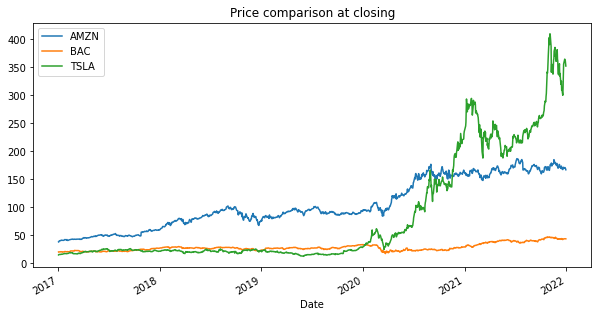

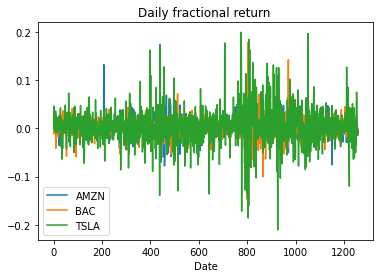


average annual return

 AMZN    0.297888
BAC     0.156717
TSLA    0.639529
dtype: float64

covariance matrix

           AMZN       BAC      TSLA
AMZN  0.086204  0.027627  0.065491
BAC   0.027627  0.113689  0.050563
TSLA  0.065491  0.050563  0.361932


In [92]:
# stocks to be analyzed
#stocks = ['AAPL','AMZN','NFLX','GOOG', 'NYT', 'META', 'MSFT', 'TSLA', 'KO', 'BAC']
stocks = ['AMZN','BAC','TSLA']
#stocks = ['AMZN','GOOG','TSLA', 'META']

# time frame for analysis
start_date = '2017-01-01'
end_date = '2022-01-01'

# average number of days per year that operations can be carried out
NUM_TRADING_DAYS = 252

# method to get stock price history
def download_data():
  stock_data = {}
  for stock in stocks:
    ticker = yf.Ticker(stock)
    stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close'] # price at closing of stocks
  return pd.DataFrame(stock_data)

# calculate daily return from history
def calculate_return(data):
  log_return = np.log(data/data.shift(1)) # daily return
  return log_return[1:] # removing first row with NaN values

# call to get history
dataset = download_data()
print('Price History\n', dataset)

# plot of stock prices over time
dataset.plot(figsize=(10,5))
plt.title("Price comparison at closing")
plt.show()

# daily fractional return plot
frac_return = {}
for stock in stocks:
    frac_return[stock] = [(price - dataset[stock][max(i_p-1, 0)])/dataset[stock][max(i_p-1, 0)] for i_p, price in enumerate(dataset[stock])]
    plt.plot(frac_return[stock], label=stock)
plt.xlabel('Date')
plt.legend()
plt.title('Daily fractional return ') # price fluctuation
plt.show()

# getting daily returns
daily_returns = calculate_return(dataset)
anual_returns = daily_returns.mean() * NUM_TRADING_DAYS # average annual return
cov_matrix = daily_returns.cov() * NUM_TRADING_DAYS # annual return covariance matrix

print('\naverage annual return\n\n', anual_returns)
print('\ncovariance matrix\n\n', cov_matrix)

## Definitions

In [93]:
# covariance matrix
S = cov_matrix.to_numpy()

# symmetric matrix form
S_ = np.divide(S + S.transpose(), 2)

# vector r with returns
r = anual_returns.to_numpy()

# objective function
def f(x, gamma = 1):
  return (0.5*gamma)*np.dot(np.dot(x.T,S),x) - np.dot(r.T,x)

# function gradient
def df(x, gamma = 1):
    return gamma*np.dot(S_,x.T) - r

# function hessian
def hessian(gamma = 1):
  return gamma * S_

# normalization of weights for restriction
def normaliza_pesos(pesos):
  return pesos / sum(pesos)

# creation of random weights
def peso_aleatorio(dimension = len(stocks)):
  p = np.random.rand(dimension)
  return normaliza_pesos(p)

# expected return for a given vector of weights
def retorno_esperado(pesos):
  return np.sum(pesos @ anual_returns.to_numpy())

# level of risk or volatility
def volatilidade(pesos):
    return np.sqrt(np.dot(pesos,np.dot(pesos,S)))

# ratio between return and risk
def proporcao(ret, vol):
  return ret/vol

## Efficient Frontier Curve

The efficient frontier curve values ​​investment portfolios on a fractional return scale versus a risk scale.

The efficient frontier graphically represents the possible portfolios that maximize returns for the risk assumed.

The shape of the curve is positively inclined, as the greater the risk, the greater the return to compensate for your investment.

![](https://drive.google.com/uc?id=1O2C8vSPwKTm7cfW3UOyTytOaWreGJE48)

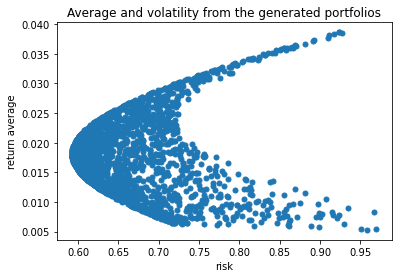

In [105]:
# efficient frontier curve plot
def portfolio_aleatorio(returns):
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(peso_aleatorio(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # recursion to reduce outliers
    if sigma > 2: return portfolio_aleatorio(returns)
    return mu, sigma

n_portfolios = 2000
n_obs = 1000
dados_teste = np.random.randn(len(stocks), n_obs)

means, stds = np.column_stack([
    portfolio_aleatorio(dados_teste)
    for _ in range(n_portfolios)
])

# plotting the efficient frontier curve for several different portfolios of our model
fig = plt.figure()
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('risk')
plt.ylabel('return average')
plt.title('Average and volatility from the generated portfolios')
plt.show()

## Gradient Descent Algorithm

Initial weight
 [0.45027008327274204 0.3281125067971629  0.22161740993009496] 

Result Dataframe
     iteration      f(x)    return  return/risk ratio
0            0  0.308262  0.327282           1.186553
1            1  0.628969  0.403756           1.215573
2            2  0.832933  0.421378           1.207043
3            3  0.963362  0.427613           1.202803
4            4  1.049058  0.429559           1.200708
..         ...       ...       ...                ...
246        246  1.252338  0.421360           1.206541
247        247  1.249739  0.425234           1.208081
248        248  1.251319  0.422896           1.207173
249        249  1.248988  0.426598           1.208563
250        250  1.250788  0.424174           1.207662

[251 rows x 4 columns]
Maximum return with following capital division: [0.3328877199167706  0.21521719188685884 0.4518950881963706 ]


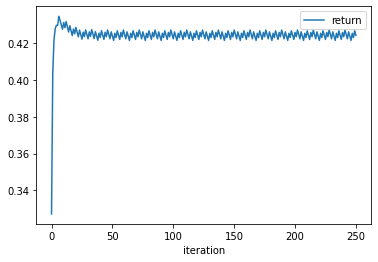

In [103]:
# lists to store iteration results
lista_iter = []
lista_x= []
lista_x_norm= []
lista_fx= []
lista_dfx= []
lista_dfx_norm = []
lista_retorno= []
lista_prop = []
lista_dk = []
lista_dk_norm = []

# starting with random weight
peso_inicial = peso_aleatorio()
print("Initial weight\n", peso_inicial, "\n")

# initial values
k = 0
proximo_x = peso_inicial
error = 1e-5
alpha = 1e-5
limite_iteracoes = 250
risk_free = 0.5
passo_fixo = 0.5

# main loop
while k <= limite_iteracoes:

  grad = df(proximo_x, risk_free)
  #print('gradient with k =', k, ': ', grad)
  
  # testing convergence to stop
  if np.linalg.norm(grad) < error: break
  
  dk = -1 * grad # descent direction
  #print('dk with k =', k, ': ', dk)

  # starting linear search (backtracking)
  lamb_bt = 1 # initial lambda
  while( f(proximo_x + lamb_bt*dk, risk_free) >= f(proximo_x, risk_free) + alpha*lamb_bt*(np.dot(grad.T,dk)) ):
    lamb_bt = 0.5 * lamb_bt

  # starting exact linear search
  #lamb_exata = np.dot(grad.T,grad) / np.dot((grad.T @ hessian(risk_free)), grad)

  # saving data
  lista_x.append(proximo_x)
  lista_x_norm.append(normaliza_pesos(proximo_x))
  lista_fx.append(-f(proximo_x, risk_free))
  lista_dfx.append(grad)
  lista_dfx_norm.append(normaliza_pesos(grad))
  lista_retorno.append(retorno_esperado(normaliza_pesos(proximo_x)))
  lista_iter.append(k)
  lista_prop.append(proporcao(retorno_esperado(normaliza_pesos(proximo_x)), volatilidade(normaliza_pesos(proximo_x))))
  lista_dk.append(dk)
  lista_dk_norm.append(normaliza_pesos(dk))

  # calculating next x
  proximo_x = proximo_x + lamb_bt*dk
  #print('x with k =', k, ': ', proximo_x)

  # checking negative values ​​in the next x (boundary conditions)
  def correct_negative_values():
    for i, elem in enumerate(proximo_x):
      if(elem < 0):
        #print('proximo_x with negative value ', elem,'at k = ', k, 'index ', i)
        proximo_x[i] *= -1
      
  # checking massive capital for a single stock
  def corrects_massive_investment():
    pn = normaliza_pesos(proximo_x)
    for i, elem in enumerate(pn):
      if(elem > 0.2): # capital limit of 20% for single stock
        proximo_x[i] *= 0.9 # reduce 10% of investment

  correct_negative_values() # check for boundary conditions

  corrects_massive_investment() # check for capital limit, it can affect convergence

  # iteration increment
  k = k + 1

print("Result Dataframe")
dataframe = pd.DataFrame(list(zip(lista_iter, lista_fx, lista_retorno, lista_prop)), columns=['iteration','f(x)','return','return/risk ratio'])
#print(dataframe.to_string())
print(dataframe)

#dataframe.plot(x='iteration', y='f(x)')
dataframe.plot(x='iteration', y='return')
#dataframe.plot(x='iteration', y='return/risk ratio')

print('Maximum return with following capital division:', normaliza_pesos(proximo_x))

## Plot

In [96]:
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()

In [97]:
# plot of descent directions
try: vector_plot(lista_dk_norm)
except: print('not a 3d vector')

In [98]:
# x vector plot
try: vector_plot(lista_x_norm)
except: print('not a 3d vector')